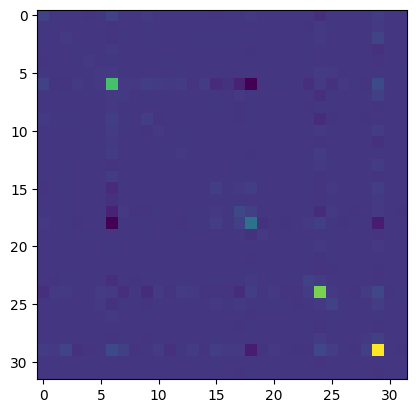

In [47]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

# set number of assets (= number of qubits)
num_assets = 32
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

def to_unitary(matrix):
    Q, R = np.linalg.qr(matrix)
    return Q
def to_state(vector):
    return vector / np.linalg.norm(vector)
portfolio = PortfolioOptimization(
    expected_returns=to_state(mu), covariances=to_unitary(sigma), risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))
        

In [48]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


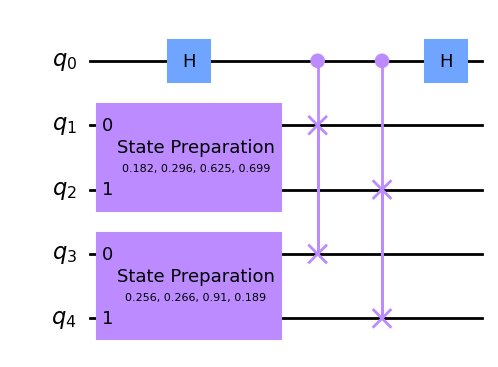

In [18]:
import qiskit
import numpy as np

num_assets = 4
# generate random x and mu such that they has length = 1
x = np.random.rand(num_assets)
x = x / np.linalg.norm(x)
mu = np.random.rand(num_assets)
mu = mu / np.linalg.norm(mu)

num_qubit_assets = int(np.log2(num_assets))
qc1 = qiskit.QuantumCircuit(num_qubit_assets)
qc1.prepare_state(x)
qc2 = qiskit.QuantumCircuit(num_qubit_assets)
qc2.prepare_state(mu)

qc = qiskit.QuantumCircuit(1 + 2 * num_qubit_assets)
qc.h(0)
qc.compose(qc1, qubits=[*range(1, 1 + num_qubit_assets)], inplace=True)
qc.compose(qc2, qubits=[*range(1 + num_qubit_assets, 1 + num_qubit_assets * 2)], inplace=True)
for i in range(1, num_qubit_assets + 1):
    qc.cswap(0, i, i + num_qubit_assets)
qc.h(0)
qc.draw('mpl')

In [14]:
import numpy as np

cov_matrix = np.array([[1, 0.8,0], 
            [0.8, 1, 0.3],
            [0, 0.3, 0.7]])

# Step 2: Perform SVD
Q, R = np.linalg.qr(cov_matrix)

Original Covariance Matrix:
 [[1.  0.8 0. ]
 [0.8 1.  0.3]
 [0.  0.3 0.7]]

Modified Reconstructed Matrix:
 [[ 0.95315132  0.85160198 -0.02663701]
 [ 0.85160198  0.94316244  0.32933962]
 [-0.02663701  0.32933962  0.68485485]]


{'0': 1926, '1': 8074}


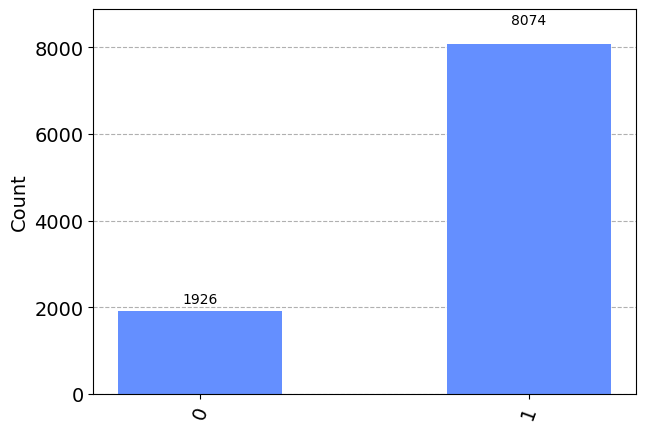

In [30]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram

# Create a quantum circuit with 1 qubit and 1 classical bit for measurement
qc = QuantumCircuit(1, 1)
qc.prepare_state([1/np.sqrt(5), 2/np.sqrt(5)])
# Step 2: Apply Y gate
qc.z(0)

# Step 3: Rotate for Y measurement (measure in the Y-basis)
# qc.sdg(0)  # Apply S† gate
#qc.h(0)  # Hadamard gate to rotate to the computational basis

# Step 4: Measure
qc.measure(0, 0)

# Execute the circuit on the qasm simulator
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts()

# Display the measurement results
print(counts)
plot_histogram(counts)


In [39]:
# create 8-dimensional binary vector
for i in [2,4,8,16,32,64]:
    x = np.random.randint(2, size=i)
    x = x /np.sqrt(np.sum(x))
    qc = qiskit.QuantumCircuit(int(np.log2(len(x))))
    qc.prepare_state(x)
    from qiskit.compiler import transpile
    from qiskit.providers.fake_provider import FakeQasmSimulator
    qc1 = transpile(qc, backend = FakeQasmSimulator())

    print(qc1.depth())

1
1
10
26
57
118
